Bagpipes: Latex distribution not found, plots may look strange.


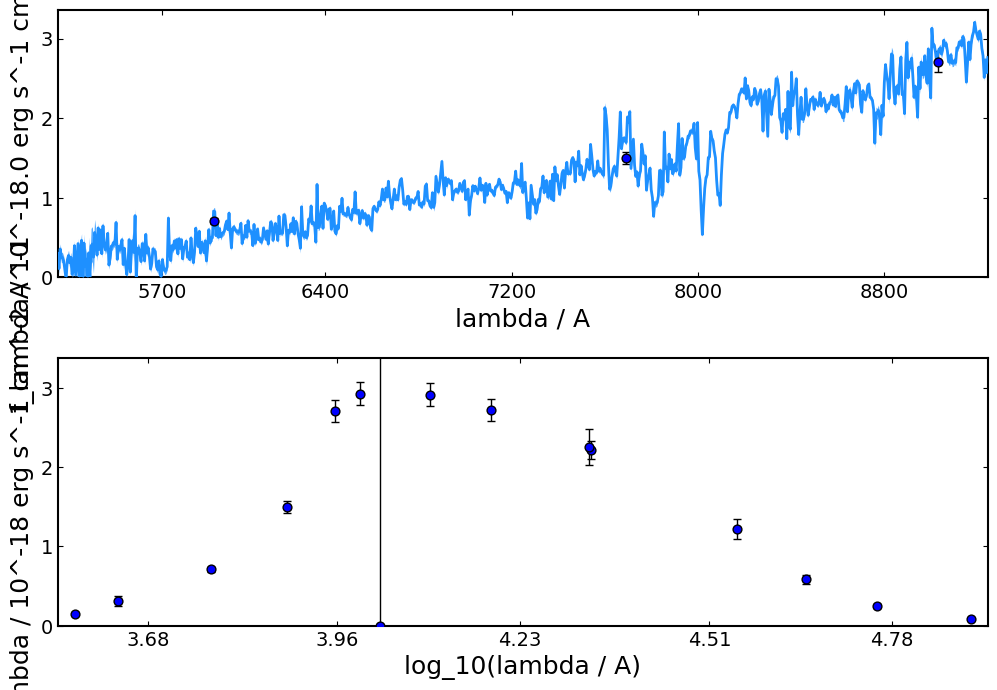

In [1]:
import numpy as np
import bagpipes as pipes

from astropy.io import fits


def load_goodss(ID):
    """ Load UltraVISTA photometry from catalogue. """

    # load up the relevant columns from the catalogue.
    cat = np.loadtxt("hlsp_candels_hst_wfc3_goodss-tot-multiband_f160w_v1-1photom_cat.txt",
                     usecols=(10, 13, 16, 19, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55,
                              11, 14, 17, 20, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56))
    
    # Find the correct row for the object we want.
    row = int(ID) - 1

    # Extract the object we want from the catalogue.
    fluxes = cat[row, :15]
    fluxerrs = cat[row, 15:]

    # Turn these into a 2D array.
    photometry = np.c_[fluxes, fluxerrs]

    # blow up the errors associated with any missing fluxes.
    for i in range(len(photometry)):
        if (photometry[i, 0] == 0.) or (photometry[i, 1] <= 0):
            photometry[i, :] = [0., 9.9 * 10 ** 99.]

    # Enforce a maximum SNR of 20, or 10 in the IRAC channels.
    for i in range(len(photometry)):
        if i < 10:
            max_snr = 20.

        else:
            max_snr = 10.

        if photometry[i, 0] / photometry[i, 1] > max_snr:
            photometry[i, 1] = photometry[i, 0] / max_snr

    return photometry



def bin(spectrum, binn):
    """ Bins up two or three column spectral data by a specified factor. """

    binn = int(binn)
    nbins = len(spectrum) // binn
    binspec = np.zeros((nbins, spectrum.shape[1]))

    for i in range(binspec.shape[0]):
        spec_slice = spectrum[i*binn:(i+1)*binn, :]
        binspec[i, 0] = np.mean(spec_slice[:, 0])
        binspec[i, 1] = np.mean(spec_slice[:, 1])

        if spectrum.shape[1] == 3:
            binspec[i,2] = (1./float(binn)
                            *np.sqrt(np.sum(spec_slice[:, 2]**2)))

    return binspec


def load_vandels_spec(ID):
    """ Loads VANDELS spectroscopic data from file. """

    hdulist = fits.open("VANDELS_CDFS_" + ID + ".fits")

    spectrum = np.c_[hdulist[1].data["WAVE"][0],
                     hdulist[1].data["FLUX"][0],
                     hdulist[1].data["ERR"][0]]

    mask = (spectrum[:,0] < 9250.) & (spectrum[:,0] > 5250.)

    return bin(spectrum[mask], 2)


def load_both(ID):
    spectrum = load_vandels_spec(ID)
    phot = load_goodss(ID)
    
    return spectrum, phot


goodss_filt_list = np.loadtxt("filters/goodss_filt_list.txt", dtype="str")

galaxy = pipes.galaxy("017433", load_both, filt_list=goodss_filt_list)
#galaxy = pipes.galaxy("017433", load_data = load_vandels_spec, filt_list=goodss_filt_list, photometry_exists=False)


fig = galaxy.plot()

In [30]:
dblplaw = {}                        
dblplaw["tau"] = (0., 15.)            
dblplaw["alpha"] = (0.01, 1000.)
dblplaw["beta"] = (0.01, 1000.)
dblplaw["alpha_prior"] = "log_10"
dblplaw["beta_prior"] = "log_10"
dblplaw["massformed"] = (1., 15.)
dblplaw["metallicity"] = (0.1, 2.)
dblplaw["metallicity_prior"] = "log_10"

nebular = {}
nebular["logU"] = -3.

dust = {}
dust["type"] = "CF00"
dust["eta"] = 2.
dust["Av"] = (0., 2.0)
dust["n"] = (0.3, 2.5)
dust["n_prior"] = "Gaussian"
dust["n_prior_mu"] = 0.7
dust["n_prior_sigma"] = 0.3

fit_instructions = {}
fit_instructions["redshift"] = (0.75, 1.25)
fit_instructions["t_bc"] = 0.01
fit_instructions["redshift_prior"] = "Gaussian"
fit_instructions["redshift_prior_mu"] = 0.9
fit_instructions["redshift_prior_sigma"] = 0.05
fit_instructions["dblplaw"] = dblplaw 
fit_instructions["nebular"] = nebular
fit_instructions["dust"] = dust

In [31]:
fit_instructions["veldisp"] = (1., 1000.)   #km/s
fit_instructions["veldisp_prior"] = "log_10"

In [32]:
calib = {}
calib["type"] = "polynomial_bayesian"

calib["0"] = (0.5, 1.5) # Zero order is centred on 1, at which point there is no change to the spectrum.
calib["0_prior"] = "Gaussian"
calib["0_prior_mu"] = 1.0
calib["0_prior_sigma"] = 0.25

calib["1"] = (-0.5, 0.5) # Subsequent orders are centred on zero.
calib["1_prior"] = "Gaussian"
calib["1_prior_mu"] = 0.
calib["1_prior_sigma"] = 0.25

calib["2"] = (-0.5, 0.5)
calib["2_prior"] = "Gaussian"
calib["2_prior_mu"] = 0.
calib["2_prior_sigma"] = 0.25

fit_instructions["calib"] = calib

In [33]:
mlpoly = {}
mlpoly["type"] = "polynomial_max_like"
mlpoly["order"] = 2

In [34]:
noise = {}
noise["type"] = "white_scaled"
noise["scaling"] = (1., 10.)
noise["scaling_prior"] = "log_10"
fit_instructions["noise"] = noise

In [35]:
fit = pipes.fit(galaxy, fit_instructions, run="spectroscopy")
fit.fit(verbose=True, sampler = 'nautilus')


Bagpipes: fitting object 017433

Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 62     | 1        | 4        | 92200    | N/A    | 4627  | -1129.09 

Completed in 517.3 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
calib:0                        1.066      1.096      1.129
calib:1                       -0.207     -0.182     -0.156
calib:2                        0.078      0.091      0.102
dblplaw:alpha                  4.527      5.733      7.161
dblplaw:beta                   0.022      0.074      0.256
dblplaw:massformed            11.454     11.500     11.550
dblplaw:metallicity            0.525      0.601      0.674
dblplaw:tau                    1.380      1.982      2.498
dust:Av                        0.377 

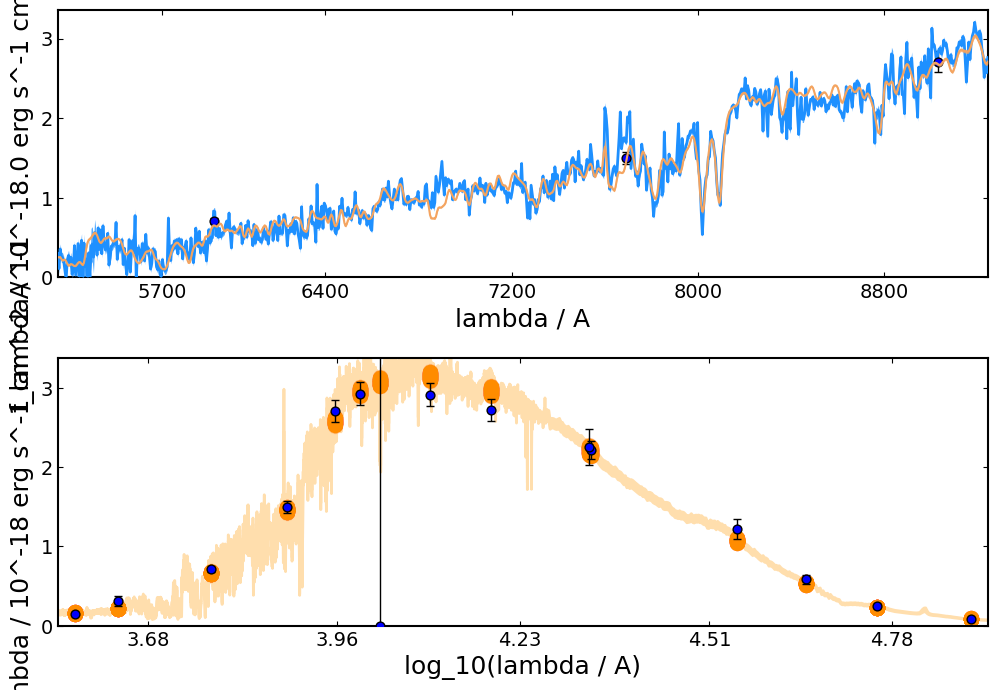

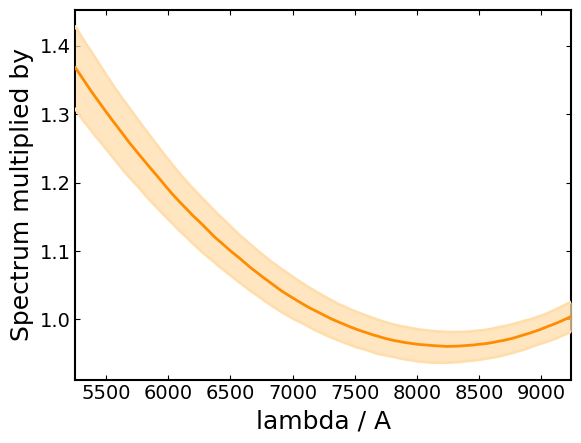

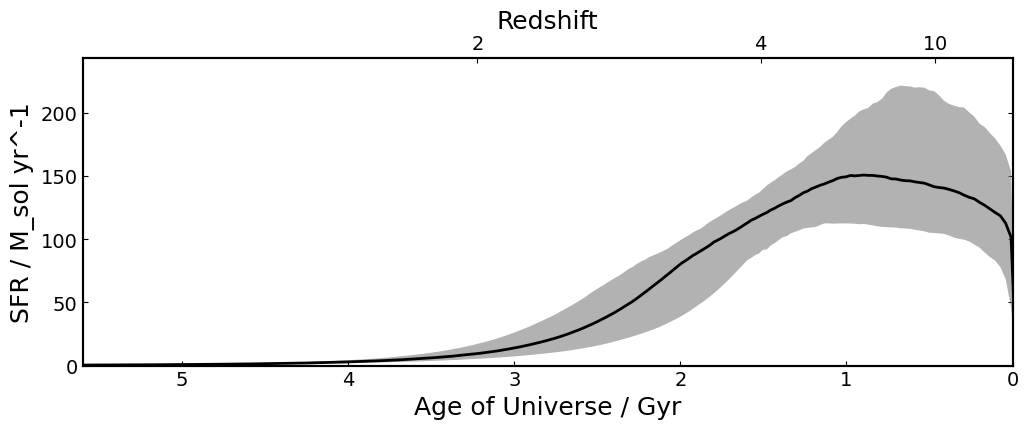

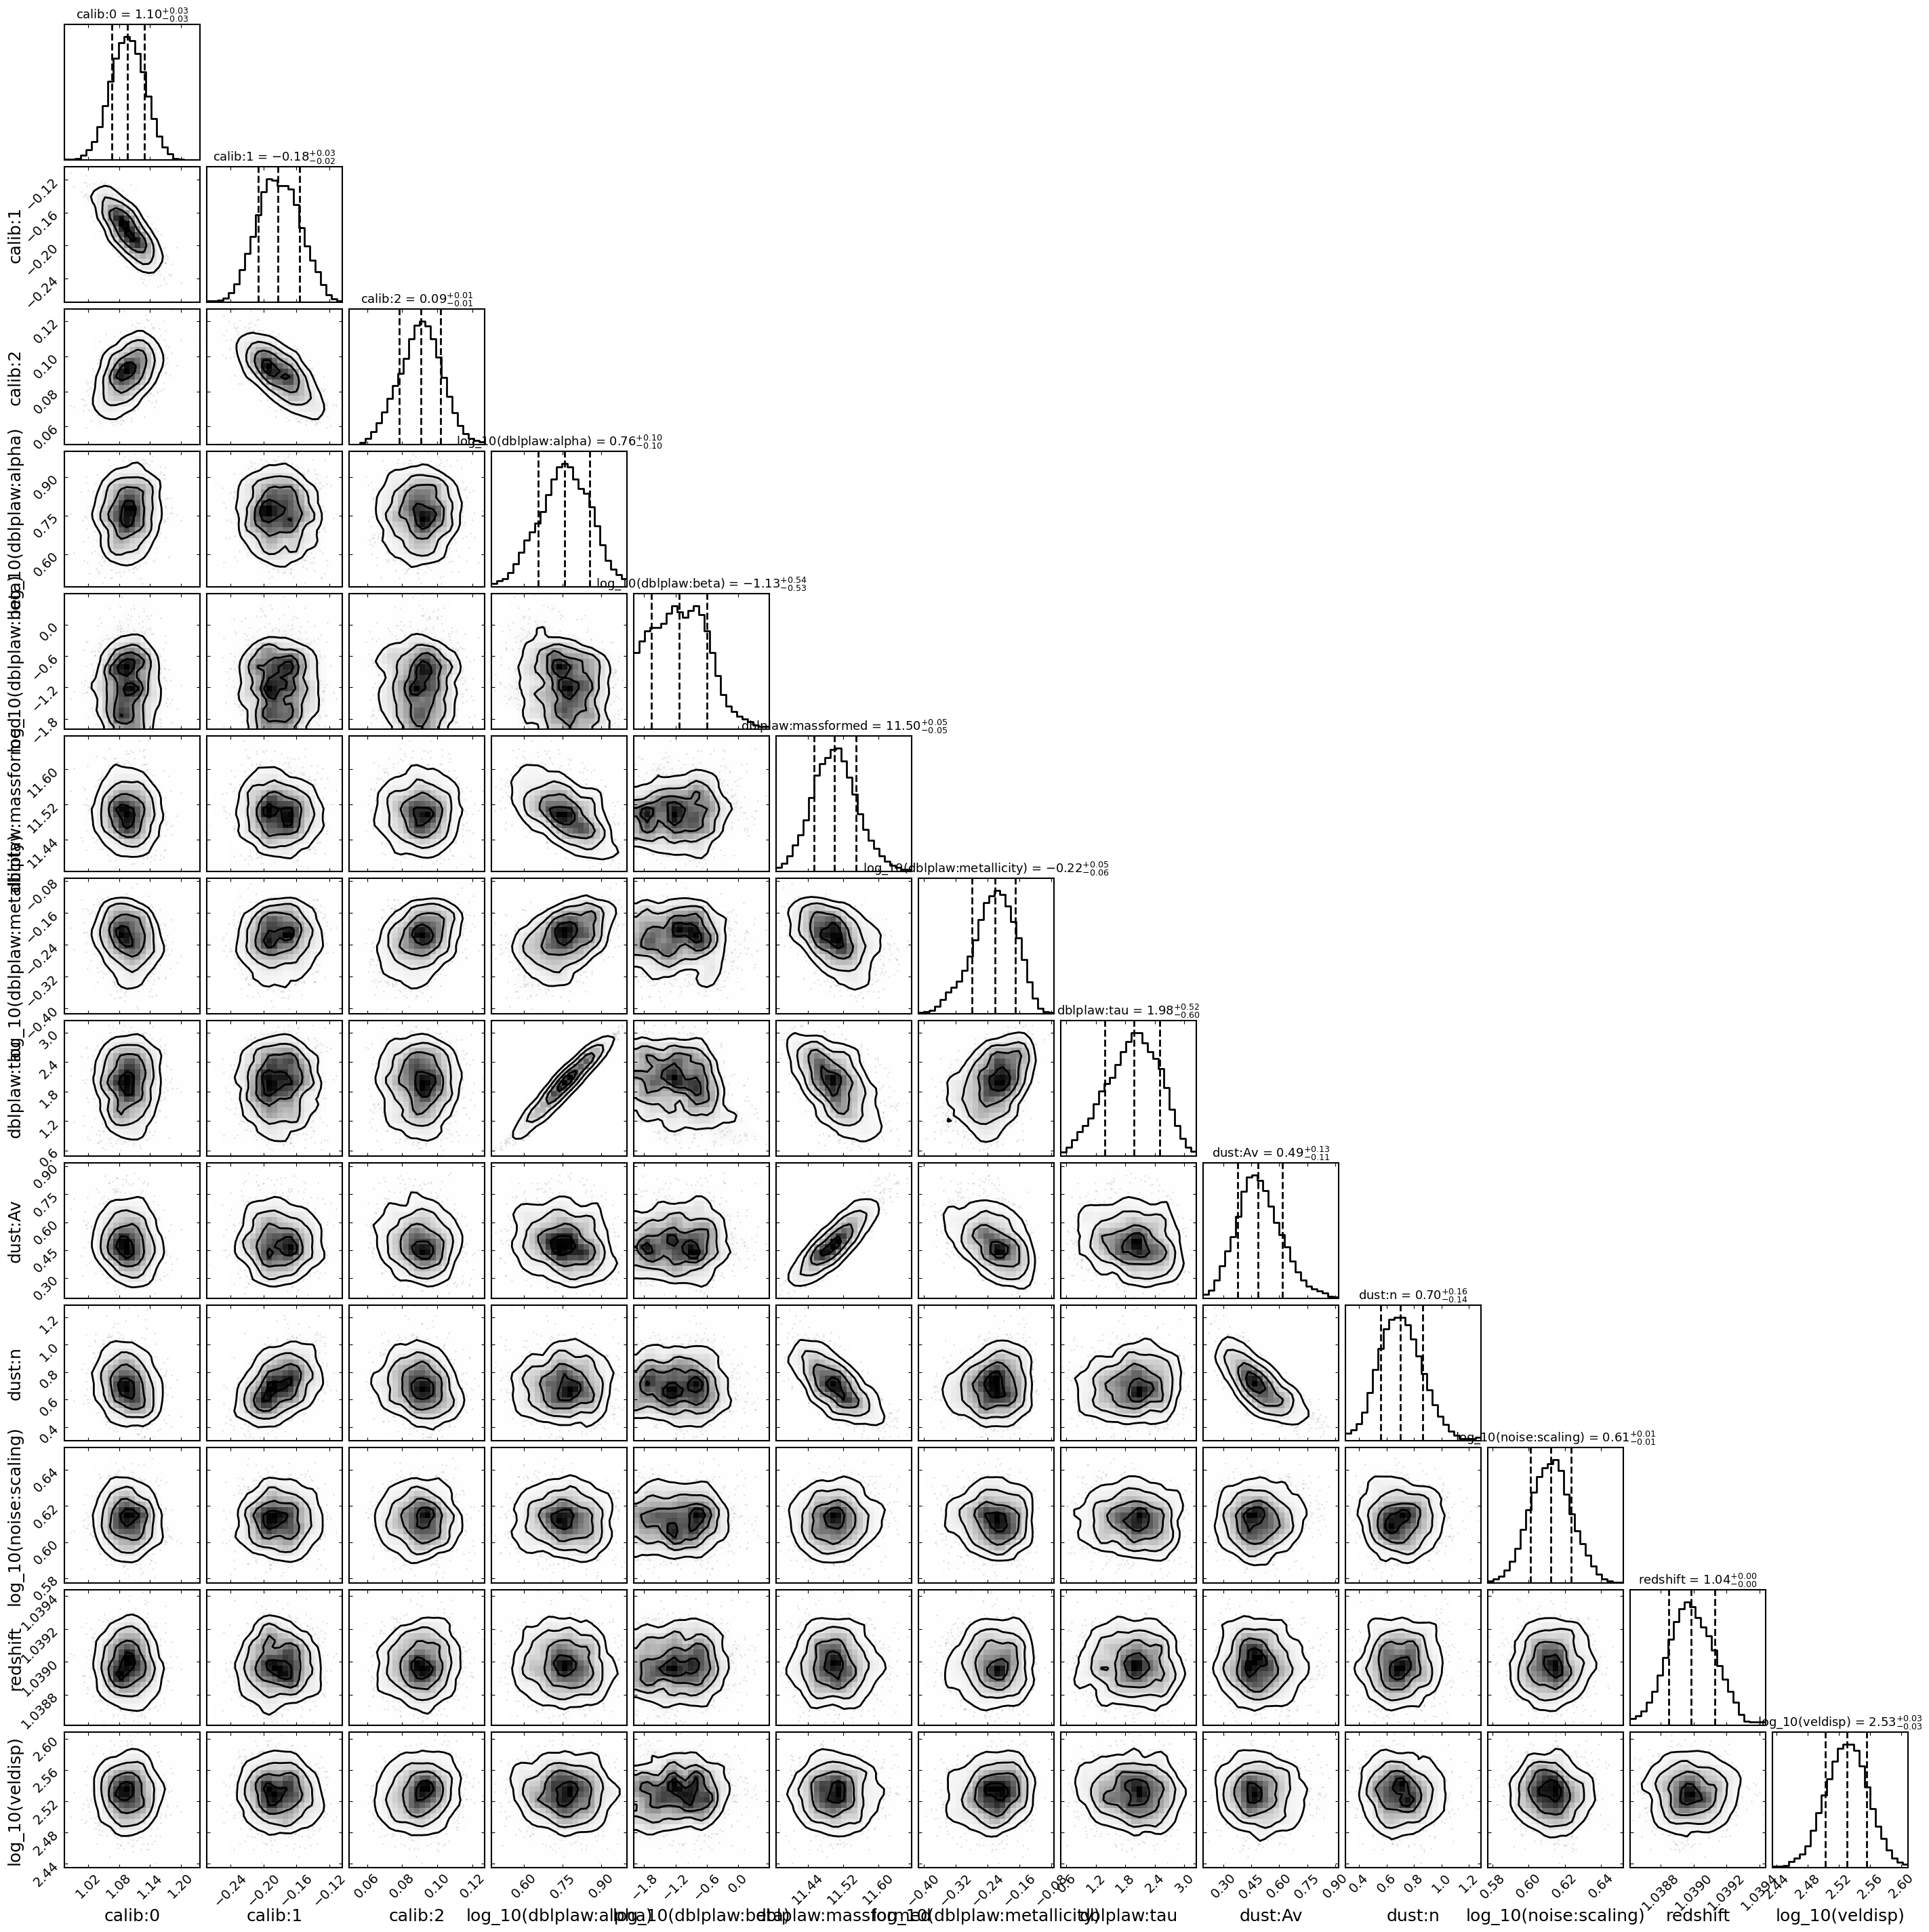

In [36]:
fig = fit.plot_spectrum_posterior(save=False, show=True)
fig = fit.plot_calibration(save=False, show=True)
fig = fit.plot_sfh_posterior(save=False, show=True)
fig = fit.plot_corner(save=False, show=True)